# Movie Recommendations
## -----------------------------------------------------------------------------------------------------
In this project I build a movie reccommendation system. The algorithim used to construct the movie recommendation system is the K-Nearest Neighbours (K-NN) classification algorithm, which essentially looks to make predictions based on closest data points. 

The algorithm works by calculating the distance between each data point and by doing so determining the nearest neighbour(s) for each point/sample. There are many distance measurers used in calculating the distance, some of the most common include: Euclidean, Manhattan, Minkowski, Hamming and Cosine distances as were studied by Chomboon et al (2015). For our model we implement the Canberra distance as our distance measure this is justified later.

## Preprocessing
### Aggregating movie ratings
 1st we seek to parse the data files and identify the highest rated film in each genre. In order to do this we must somehow aggregate the movie ratings per movie provided by different individual users. For our aggregation function we implement/take inspiration from IMDb's formula:
 
$$ Weighted Rating = \frac{Rv+Cm}{v+m} $$

$R =$ average rating for the movie (mean)  
$v =$ number of votes/ratings for the movie  
$m =$ threshold/minimum vote no. (this is to prevent assigning movies with 1 rating of 5 a total score of 5/5).  
$c =$ the mean rating across the whole data set


In [2]:
import pandas as pd
import numpy as np

u_data = pd.read_csv('ml-100k/u.data', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])

u_genre = pd.read_csv('ml-100k/u.genre', sep='|', header = None, names =['genre', 'genre_idx'])

u_info = pd.read_csv('ml-100k/u.info', header = None, sep=' ')
u_info = u_info.set_index(1).T

u_item = pd.read_csv('ml-100k/u.item', sep='|', encoding='Latin_1', header = None, names=['movie id', 
'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
'Mystery','Romance','Sci-Fi','Thriller', 'War', 'Western'])



In [3]:
x = u_data['user_id'].max()
y = u_data['item_id'].max()

In [4]:
rat_mov = np.zeros((y,x))

In [5]:
vec1 = u_data['item_id'].values
vec2 = u_data['user_id'].values
vec3 = u_data['rating'].values

In [6]:
vec1 -= 1
vec2 -= 1
rat_mov[vec1,vec2] = vec3

In [7]:
#Average Rating per movie:
sum_of_rat = np.sum(rat_mov, axis=1)
denominator = np.sum(rat_mov > 0 ,axis=1)
avg_rat = sum_of_rat/denominator

In [8]:
rat_mov.shape

(1682, 943)

In [9]:
quartile_votes = np.percentile(denominator, range(0, 100, 25), interpolation = 'midpoint')
quartile_votes

array([ 1.,  6., 27., 80.])

In [10]:
#Rating per movie inspired by IMDB formula
#The ratio's accounts for the views 
#avg_rat = average rating for the movie (mean) 
#v = number of votes/ratings for the movie 
#m = a threshold/minimum vote no. (this is to protect against assigning movies with 1 rating of 5 a total
#score of 5/5)
#c = the mean rating across the whole data set

c = np.mean(rat_mov[rat_mov>0])
v = np.sum(rat_mov > 0 ,axis=1)
m = quartile_votes[1]

rating =(v/(v+m)) * avg_rat + (m/(v+m)) * c

In [11]:
#Top rated movies in each genre
genres = u_item[u_item.columns[5:]].values.astype(float)
row, col = np.where(genres>0)
genres[row, col] = rating[row]

In [12]:
# for i, (genre, loc) in enumerate(zip(list_of_genres, genres.argmax(0))):
#     movie = u_item['movie title'].values[loc]
#     print(f'{genre:11s} : {movie}')

In [13]:
#genres.argmax(0)
top_rated = []
for i in range(len(genres[0,:])):
    top_rated.append(np.where(genres[:,i] == genres[:,i].max()))

In [14]:
list_of_genres = u_item.columns[5:]
Top_g = dict((g,0) for g in list_of_genres)
k = list(Top_g.keys())
for i in range(len(top_rated)):
    for j in np.unique(top_rated[i][0]):
        mov = u_item[u_item['movie id']==(j+1)].values.astype(str)
        Top_g[k[i]] = (mov[0][1])

In [15]:
for i in Top_g.keys():
    print(f'{i:11s} : {Top_g[i]}')

unknown     : unknown
Action      : Star Wars (1977)
Adventure   : Star Wars (1977)
Animation   : Close Shave, A (1995)
Childrens   : Wizard of Oz, The (1939)
Comedy      : Close Shave, A (1995)
Crime       : Usual Suspects, The (1995)
Documentary : Hoop Dreams (1994)
Drama       : Schindler's List (1993)
Fantasy     : Star Kid (1997)
Film-Noir   : Manchurian Candidate, The (1962)
Horror      : Psycho (1960)
Musical     : Wizard of Oz, The (1939)
Mystery     : Rear Window (1954)
Romance     : Casablanca (1942)
Sci-Fi      : Star Wars (1977)
Thriller    : Close Shave, A (1995)
War         : Schindler's List (1993)
Western     : High Noon (1952)


-

## K-NN model

In the code for this task, the scikit-learn library’s functions, `NearestNeighbors()` and `.kneighbours()`, are used to fit the training data and compute the neighbours and distance matrix. According to scikit-learn.org (2019) `sklearn.neighbors.DistanceMetric` the distance metrics intended for ‘integer-valued’ and  ‘real-valued vector spaces’ are the Hamming, Cranberra and BrayCurtis distances. Given that the data we are working with, movie ratings, has an integer-value space of 1-5 (and 0 where there are no ratings), it is most appropriate to implement one of the aforementioned distance metrics. After having tested all three distance metrics when fitting the nearest neighbours we find that when using the Cranberra distance metric (with k = 9)  we achieve the lowest out of sample Mean Absolute Error (MAE) of 0.78198.

The Canberra distance between vectors a and b, as stated by Surya, V. B et al (2019), is a weighted version of the Manhattan distance and is calculated as follows:

$$ CanberraDistance(a,b) = \sum \limits_{i=1}^{n} \frac{\mid{a_{i}-b_{i}\mid}}{\mid{a_i}\mid+\mid{b_i}\mid}$$

It is the absolute difference of the values of vector a and b divided by the individual absolutes of the values of vector a and b summed.

In [16]:
from sklearn.neighbors import NearestNeighbors

In [17]:
u_train1 = pd.read_csv('ml-100k/u1.base', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_train2 = pd.read_csv('ml-100k/u2.base', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_train3 = pd.read_csv('ml-100k/u3.base', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_train4 = pd.read_csv('ml-100k/u4.base', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_train5 = pd.read_csv('ml-100k/u5.base', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])

In [18]:
trains = [u_train1, u_train2, u_train3, u_train4, u_train5]

In [19]:
u_test1 = pd.read_csv('ml-100k/u1.test', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_test2 = pd.read_csv('ml-100k/u2.test', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_test3 = pd.read_csv('ml-100k/u3.test', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_test4 = pd.read_csv('ml-100k/u4.test', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])
u_test5 = pd.read_csv('ml-100k/u5.test', sep='\t', header = None, names = ['user_id', 'item_id', 'rating','timestamp'])

In [20]:
tests = [u_test1, u_test2, u_test3, u_test4, u_test5]

In [27]:
E_forplot = []
K_forplot = []
MAE_vec = np.zeros((9)) #This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to optimal K.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for neighbors in range(1,10): 
    MAEs = []
    #Cross Validation
    for i in range(len(trains)):

        #Create pivot table out of the pandas dataframe
        train = trains[i].pivot(*trains[i].columns[:-1])
        #Save the respective movieids so that can reindex correctly later
        re_index = train.columns

        #Fill the Nans with zeros to then be filled with averages
        train_ = train.fillna(0)
        train_ = train_.values

        #Calculate the average rating per movie
        #sum the ratings
        train_sum_of_rat = np.sum(train_, axis=0)
        #count of the ratings
        train_denominator = np.sum(train_ > 0 ,axis=0)
        #Avg rating per movie
        train_avg_rat = train_sum_of_rat/train_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(train_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(train_[train_>0])
        v_ = np.sum(train_ > 0 ,axis=0)
        m_ = quartile_votes[1]

        rating_train =(v_/(v_+m_)) * train_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        t_row, t_col = np.where(train_ == 0)
        t_row

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        train_fit = train_.copy()
        train_fit[t_row,t_col] = rating_train[t_col]

        #Fit training data
        n = NearestNeighbors(neighbors, metric = 'canberra')
        n.fit(train_fit)

        #split into distance and user/neighbour matrix 
        dist, user = n.kneighbors()


        #calculate weightings
        denom = np.sum((1/dist), axis=1)
        weighting = (1/dist)/denom[:,None]
        if (dist==0).any():
            print('error')

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d = train_fit[user]

        #Using einsum multiply out users, ratings and weightings
        #Whilst collapsing on weightings
        reccomendations = np.einsum('ukr, uk -> ur', three_d, weighting)

        #prep test data:
        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomendations, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomendations, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(round(predictions.loc[usr, itm]))
            except:
                p.append(3) #Here we fill movies that both users havent seen with a niave value

        MAE = np.mean(np.fabs(tests[i]['rating'] - p))

        MAEs.append(MAE)

    print((neighbors, np.mean(MAEs), MAEs))
    MAE_vec[neighbors-1]= np.mean(MAEs)
    E_forplot.append(np.mean(MAEs))
    K_forplot.append(neighbors)

(1, 0.7859400000000001, [0.80295, 0.78615, 0.77965, 0.77835, 0.7826])
(2, 0.78467, [0.8015, 0.78505, 0.77795, 0.77685, 0.782])
(3, 0.7834, [0.80065, 0.78295, 0.7766, 0.7777, 0.7791])
(4, 0.7829699999999999, [0.8006, 0.7813, 0.77635, 0.7772, 0.7794])
(5, 0.78303, [0.80055, 0.78305, 0.7757, 0.77685, 0.779])
(6, 0.78257, [0.80035, 0.78155, 0.7757, 0.77635, 0.7789])
(7, 0.7820799999999999, [0.7991, 0.78075, 0.7756, 0.77655, 0.7784])
(8, 0.7821499999999999, [0.7977, 0.781, 0.7766, 0.7768, 0.77865])
(9, 0.7819800000000001, [0.79735, 0.7811, 0.7758, 0.7769, 0.77875])


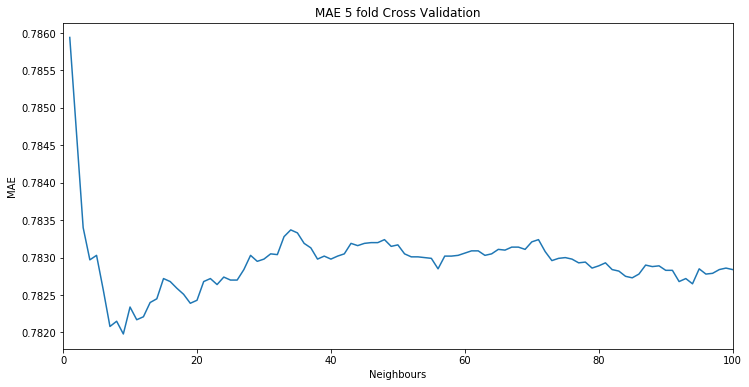

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(K_forplot, E_forplot)
plt.ylabel('MAE')
plt.xlabel('Neighbours')
plt.xlim(0,100)
plt.title('MAE 5 fold Cross Validation')
#plt.show()
#plt.savefig('MAE_Cross_Validation.png', transparent=False)

In [40]:
#Minimizing neighbours:
Best_Neighbors_Score = (np.argmin(MAE_vec)+1,E_forplot[np.argmin(MAE_vec)])
Best_Neighbors_Score

(9, 0.7819800000000001)

### Task3
Extend your code from Task 2 to include the user details from u.user as part of the matching process. What if any difference does this make to the results? You will need to think carefully about how you convert the fields in u.user into suitable parameters.


In [29]:
u_user = pd.read_csv('ml-100k/u.user', sep='|', header = None, names = ['user id', 'age', 'gender', 'occupation', 'zipcode'])

In [30]:
occ = pd.get_dummies(u_user['occupation'])
occ_d = occ.values
occus_n = occ_d.shape
age = u_user['age'].values

In [31]:
gend = u_user['gender'].values
g_b = (gend == 'F')
u_user.index
occ = u_user['occupation'].values
np.unique(occ)
occus_n[1]

21

In [32]:
#Including gender dummy
MAE_vec_g = np.zeros((9)) #This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,1+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,1:]= t3_fit

        t_matrix[:,0]= g_b


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,1:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_g[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.7857 [0.8008, 0.78725, 0.7798, 0.77915, 0.7815]
2 0.78452 [0.79955, 0.7839, 0.77775, 0.779, 0.7824]
3 0.78402 [0.79965, 0.7826, 0.77775, 0.77945, 0.78065]
4 0.78352 [0.79845, 0.783, 0.77705, 0.77825, 0.78085]
5 0.78344 [0.79745, 0.784, 0.7769, 0.7775, 0.78135]
6 0.7828899999999999 [0.7971, 0.7824, 0.77785, 0.77735, 0.77975]
7 0.78208 [0.79595, 0.78155, 0.7767, 0.77665, 0.77955]
8 0.7819999999999999 [0.79515, 0.78155, 0.7766, 0.77715, 0.77955]
9 0.78189 [0.7952, 0.78165, 0.7761, 0.77705, 0.77945]


In [44]:
#Minimizing neighbours:
Best_Neighbors_Score_g = (np.argmin(MAE_vec_g)+1,MAE_vec_g[np.argmin(MAE_vec_g)])
Best_Neighbors_Score_g

(82, 0.78171)

In [33]:
#Including gender and occupation dummy
MAE_vec_g_oc = np.zeros((9))#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,1+occus_n[1]+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,1+occus_n[1]:]= t3_fit

        t_matrix[:,1:1+occus_n[1]] = occ_d

        t_matrix[:,0]= g_b


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,1+occus_n[1]:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_g_oc[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.7876700000000001 [0.80165, 0.78735, 0.7807, 0.78155, 0.7871]
2 0.78602 [0.80025, 0.78595, 0.7791, 0.77945, 0.78535]
3 0.78399 [0.79775, 0.78375, 0.7783, 0.7785, 0.78165]
4 0.7837800000000001 [0.79755, 0.7834, 0.7779, 0.7791, 0.78095]
5 0.7832399999999999 [0.7968, 0.78325, 0.77685, 0.7787, 0.7806]
6 0.7827400000000001 [0.796, 0.78265, 0.77645, 0.7781, 0.7805]
7 0.78281 [0.7967, 0.7821, 0.77595, 0.77745, 0.78185]
8 0.78266 [0.79705, 0.78145, 0.77495, 0.7784, 0.78145]
9 0.78257 [0.7966, 0.78105, 0.77545, 0.77825, 0.7815]


In [47]:
#Minimizing neighbours:
Best_Neighbors_Score_g_oc = (np.argmin(MAE_vec_g_oc)+1,MAE_vec_g_oc[np.argmin(MAE_vec_g_oc)])
Best_Neighbors_Score_g_oc

(36, 0.78154)

In [34]:
#Including gender and age 
MAE_vec_g_a = np.zeros((9))
#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,2+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,2:]= t3_fit

        t_matrix[:,1] = age

        t_matrix[:,0]= g_b


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,2:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_g_a[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.78553 [0.80125, 0.78485, 0.7797, 0.77865, 0.7832]
2 0.78526 [0.80115, 0.78335, 0.7797, 0.7793, 0.7828]
3 0.78359 [0.7989, 0.78295, 0.7776, 0.7785, 0.78]
4 0.78311 [0.79845, 0.782, 0.7774, 0.77765, 0.78005]
5 0.78266 [0.7976, 0.7817, 0.77675, 0.77645, 0.7808]
6 0.7825099999999999 [0.79685, 0.78135, 0.7769, 0.77705, 0.7804]
7 0.78203 [0.7957, 0.7814, 0.7765, 0.77675, 0.7798]
8 0.7818200000000001 [0.79555, 0.7816, 0.7761, 0.77605, 0.7798]
9 0.7812300000000001 [0.7949, 0.78105, 0.77535, 0.7761, 0.77875]


In [54]:
Best_Neighbors_Score_g_a = (np.argmin(MAE_vec_g_a)+1,MAE_vec_g_a[np.argmin(MAE_vec_g_a)])
Best_Neighbors_Score_g_a

(9, 0.7812300000000001)

In [35]:
#Including occ and age 
MAE_vec_oc_a = np.zeros((9))#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,1+occus_n[1]+width[1]))


        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,1+occus_n[1]:]= t3_fit

        t_matrix[:,1:1+occus_n[1]] = occ_d

        t_matrix[:,0]= age


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,1+occus_n[1]:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_oc_a[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.7871400000000002 [0.8004, 0.78725, 0.78075, 0.78195, 0.78535]
2 0.78586 [0.7995, 0.78465, 0.779, 0.78015, 0.786]
3 0.78392 [0.7987, 0.78255, 0.7777, 0.778, 0.78265]
4 0.7834700000000001 [0.7979, 0.7828, 0.77655, 0.7783, 0.7818]
5 0.7836000000000001 [0.79755, 0.78325, 0.77635, 0.77885, 0.782]
6 0.78267 [0.79665, 0.7811, 0.77655, 0.77725, 0.7818]
7 0.78248 [0.79615, 0.7811, 0.77645, 0.77765, 0.78105]
8 0.7824000000000001 [0.7968, 0.781, 0.77545, 0.77775, 0.781]
9 0.78217 [0.7964, 0.7811, 0.77585, 0.7774, 0.7801]


In [ ]:
Best_Neighbors_Score_oc_a = (np.argmin(MAE_vec_oc_a)+1,MAE_vec_oc_a[np.argmin(MAE_vec_oc_a)])
Best_Neighbors_Score_oc_a

In [36]:
#Including occupation dummy
MAE_vec_oc = np.zeros((9))#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,occus_n[1]+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,occus_n[1]:]= t3_fit

        t_matrix[:,:occus_n[1]] = occ_d

 


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,occus_n[1]:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_oc[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.78734 [0.8017, 0.7873, 0.7803, 0.78225, 0.78515]
2 0.78603 [0.80005, 0.7856, 0.7786, 0.78, 0.7859]
3 0.7844099999999999 [0.79945, 0.7837, 0.77815, 0.77805, 0.7827]
4 0.7839299999999999 [0.79825, 0.78295, 0.77755, 0.7783, 0.7826]
5 0.78354 [0.79765, 0.78255, 0.77665, 0.7786, 0.78225]
6 0.78277 [0.7975, 0.7809, 0.77665, 0.77815, 0.78065]
7 0.78267 [0.79735, 0.7807, 0.77635, 0.7773, 0.78165]
8 0.7824199999999999 [0.79785, 0.78085, 0.7751, 0.77735, 0.78095]
9 0.78261 [0.7974, 0.78235, 0.7752, 0.7773, 0.7808]


In [48]:
#Minimizing neighbours:
Best_Neighbors_Score_oc = (np.argmin(MAE_vec_oc)+1,MAE_vec_oc[np.argmin(MAE_vec_oc)])
Best_Neighbors_Score_oc

(23, 0.78176)

In [37]:
#Including age feature
MAE_vec_age = np.zeros((9))#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,1+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,1:]= t3_fit

        t_matrix[:,0]= age


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,1:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_age[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)

1 0.7851799999999999 [0.79985, 0.785, 0.77965, 0.77815, 0.78325]
2 0.78454 [0.8002, 0.7837, 0.7797, 0.7772, 0.7819]
3 0.78316 [0.7987, 0.78185, 0.7775, 0.77815, 0.7796]
4 0.7826 [0.7986, 0.78165, 0.7771, 0.77655, 0.7791]
5 0.7820300000000001 [0.79735, 0.7811, 0.77705, 0.7758, 0.77885]
6 0.7814499999999999 [0.79735, 0.77965, 0.7763, 0.77565, 0.7783]
7 0.78122 [0.79645, 0.77955, 0.776, 0.7759, 0.7782]
8 0.7813800000000001 [0.79575, 0.779, 0.7766, 0.77705, 0.7785]
9 0.7813000000000001 [0.79555, 0.77985, 0.77575, 0.7772, 0.77815]


In [61]:
Best_Neighbors_Score_age = (np.argmin(MAE_vec_age)+1,MAE_vec_age[np.argmin(MAE_vec_age)])
Best_Neighbors_Score_age

(7, 0.78122)

In [38]:
#Including gender and occupation dummy + age
MAE_vec_g_oc_age = np.zeros((9))#This must be the length of the range/loop for neighbors
#This loop would usually run from 1 to 100 however for time sake of examiner loop will only run to K=9.
#Also must loop from 1 otherwise there will be indexing issues when adding MAE to numpy array
for nhbrs in range(1,10):
    MAE3s = []
    for i in range(len(trains)):    
        train_t3 = trains[i].pivot(*trains[i].columns[:-1])
        tt = train_t3.fillna(0).values

        re_index = train_t3.columns

        width = tt.shape

        t_matrix = np.zeros((943,1+1+occus_n[1]+width[1]))

        #Calculate the average rating per movie
        #sum the ratings
        t3_sum_of_rat = np.sum(tt, axis=0)
        #count of the ratings
        t3_denominator = np.sum(tt > 0 ,axis=0)
        #Avg rating per movie
        t3_avg_rat = t3_sum_of_rat/t3_denominator

        #Quartiles of the count of votes per movie
        quartile_votes = np.percentile(t3_denominator, range(0, 100, 25), interpolation = 'midpoint')

        #Implement bespoke formula for rating per movie
        c_ = np.mean(tt[tt>0])
        v_ = np.sum(tt > 0 ,axis=0)
        m_ = quartile_votes[0]

        rating_train =(v_/(v_+m_)) * t3_avg_rat + (m_/(v_+m_)) * c_

        #Find col/row of zeros i.e. where needs to be filled with ratings
        ro, co = np.where(tt == 0)
        ro

        #Creat copy for nearest neighbor fitting and fill with movie ratings calculated
        t3_fit = tt.copy()
        t3_fit[ro,co] = rating_train[co]

        t_matrix[:,2+occus_n[1]:]= t3_fit

        t_matrix[:,2:2+occus_n[1]] = occ_d

        t_matrix[:,0]= g_b
        
        t_matrix[:,1]= age


        n = NearestNeighbors(nhbrs, metric = 'canberra')
        n.fit(t_matrix)
        dist3, user3 = n.kneighbors()

        denom3 = np.sum((1/dist3), axis=1)
        w3 = (1/dist3)/denom3[:,None]

        #Creat 3 dimensional Matrix with ratings and users/neighbours
        three_d_3 = t_matrix[:,2+occus_n[1]:][user3]

        #Using einsum multiply out users, ratings and weightings
        #Whilts collapsing on weightings
        reccomend3 = np.einsum('abc, ab -> ac', three_d_3, w3)

        test = tests[i].pivot(*tests[i].columns[:-1])

        #Save the respective movieids so that can reindex correctly later
        re_index_test = test.columns

        #Save userids so that can reindex later to correct user
        test.index

        #fill Nans with 0s
        test_ = test.fillna(0)
        test_ = test_.values

        #Round reccomendations
        recs_r = np.around(reccomend3, 1)

        #Calculate errors
        predictions = pd.DataFrame(reccomend3, np.arange(943) + 1, re_index)
        p = []

        for usr, itm, _, _ in tests[i].values:
            try:
                p.append(np.around(predictions.loc[usr, itm]))
            except:
                p.append(3)

        MAE3 = np.mean(np.fabs(tests[i]['rating'] - p))
        MAE3s.append(MAE3)
        MAE_vec_g_oc_age[nhbrs-1]= np.mean(MAE3s)
    print(nhbrs, np.mean(MAE3s), MAE3s)
    

1 0.78722 [0.801, 0.7869, 0.7805, 0.78105, 0.78665]
2 0.78556 [0.7994, 0.7844, 0.7787, 0.77925, 0.78605]
3 0.78406 [0.7976, 0.78345, 0.77855, 0.77925, 0.78145]
4 0.78355 [0.79715, 0.7829, 0.77775, 0.77905, 0.7809]
5 0.78328 [0.7967, 0.7833, 0.77635, 0.77875, 0.7813]
6 0.78272 [0.79565, 0.7822, 0.7768, 0.778, 0.78095]
7 0.78265 [0.79575, 0.7826, 0.77615, 0.77755, 0.7812]
8 0.7824199999999999 [0.7959, 0.781, 0.77525, 0.77845, 0.7815]
9 0.7823 [0.7959, 0.7812, 0.7753, 0.77785, 0.78125]


In [50]:
Best_Neighbors_Score_goage = (np.argmin(MAE_vec_g_oc_age)+1,MAE_vec_g_oc_age[np.argmin(MAE_vec_g_oc_age)])
Best_Neighbors_Score_goage

(38, 0.7815000000000001)

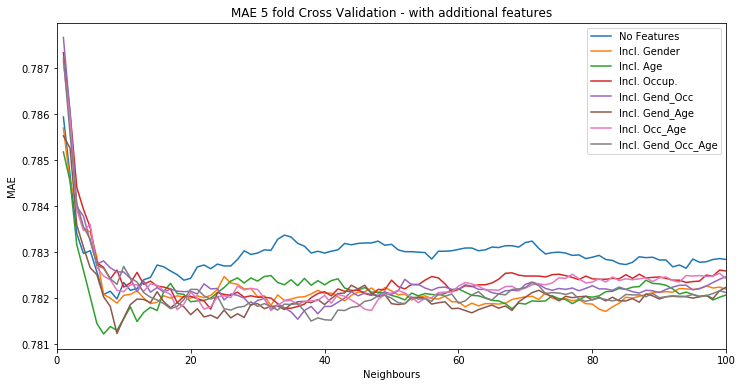

In [65]:
plt.figure(figsize=(12,6))
plt.plot(K_forplot, E_forplot, label="No Features")
plt.plot(K_forplot, list(MAE_vec_g), label="Incl. Gender")
plt.plot(K_forplot, list(MAE_vec_age), label="Incl. Age")
plt.plot(K_forplot, list(MAE_vec_oc), label="Incl. Occup.")
plt.plot(K_forplot, list(MAE_vec_g_oc), label="Incl. Gend_Occ")
plt.plot(K_forplot, list(MAE_vec_g_a), label="Incl. Gend_Age")
plt.plot(K_forplot, list(MAE_vec_oc_a), label="Incl. Occ_Age")
plt.plot(K_forplot, list(MAE_vec_g_oc_age), label = "Incl. Gend_Occ_Age")
# Place a legend to the right of this smaller subplot.
plt.legend( loc='upper right')
plt.xlim(0,100)
plt.title('MAE 5 fold Cross Validation - with additional features')
plt.ylabel('MAE')
plt.xlabel('Neighbours')


#plt.savefig('MAE_Cross_Validation_with_add_features.png', transparent=False)

## Actual Recommendations

In [39]:
train = trains[0].pivot(*trains[0].columns[:-1])
#Save the respective movieids so that can reindex correctly later
re_index = train.columns

#Fill the Nans with zeros to then be filled with averages
train_ = train.fillna(0)
train_ = train_.values

#Calculate the average rating per movie
#sum the ratings
train_sum_of_rat = np.sum(train_, axis=0)
#count of the ratings
train_denominator = np.sum(train_ > 0 ,axis=0)
#Avg rating per movie
train_avg_rat = train_sum_of_rat/train_denominator

#Quartiles of the count of votes per movie
quartile_votes = np.percentile(train_denominator, range(0, 100, 25), interpolation = 'midpoint')

#Implement bespoke formula for rating per movie
c_ = np.mean(train_[train_>0])
v_ = np.sum(train_ > 0 ,axis=0)
m_ = quartile_votes[2]

rating_train =(v_/(v_+m_)) * train_avg_rat + (m_/(v_+m_)) * c_

#Find col/row of zeros i.e. where needs to be filled with ratings
t_row, t_col = np.where(train_ == 0)
t_row

#Creat copy for nearest neighbor fitting and fill with movie ratings calculated
train_fit = train_.copy()
train_fit[t_row,t_col] = rating_train[t_col]

#Fit training data
n = NearestNeighbors(neighbors, metric = 'cosine')
n.fit(train_fit)

#split into distance and user/neighbour matrix 
dist, user = n.kneighbors()


#calculate weightings
denom = np.sum((1/dist), axis=1)
weighting = (1/dist)/denom[:,None]
if (dist==0).any():
    print('error')

#Creat 3 dimensional Matrix with ratings and users/neighbours
three_d = train_fit[user]

#Using einsum multiply out users, ratings and weightings
#Whilts collapsing on weightings
reccomendations = np.einsum('ukr, uk -> ur', three_d, weighting)

In [40]:
final_recs = np.argsort(reccomendations[0], axis=-1)[::-1][train_[0] == 0]
recos = re_index[final_recs]
t_five = []
for i in recos[:5]:
    mov = u_item[u_item['movie id']==(i)].values.astype(str)
    t_five.append(mov[0][1])

In [41]:
t_five

['Shawshank Redemption, The (1994)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Godfather, The (1972)',
 'To Kill a Mockingbird (1962)',
 '12 Angry Men (1957)']

### Sources:
Chomboon, K., Pasapichi, C., Pongsakorn, T., Kerdprasop, K., Kerdprasop, N. (2015), An empirical study of distance metrics for k-nearest neighbor algorithm, In The 3rd International Conference on Industrial Application Engineering 2015.

IMDB Help Centre, (2019), How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?,[Online]. Available from: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV# [Accessed: 01/12/2019].

scikit-learn.org, (2019), sklearn.neighbors.DistanceMetric,[Online]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html?fbclid=IwAR1ici7dQzEhsu2qK-zv-RXAigY2zGm51678j0Mv477EbL0bstbORy7bkCw [Accessed: 07/12/2019].

Surya, V. B., Alfeilat, H. A. A., Hassanat, A. B. A., Lasassmeh, O., Tarawneh, A. S., Alhasanat, M. B., Salmane, H. S. E., (2019). Effects of Distance Measure Choice on KNN Classifier Performance - A Review, Big Data 10.1089/big.2018.0175.